In [ ]:
!pip install biopython pandas numpy matplotlib seaborn scikit-learn tqdm nltk

In [ ]:
from Bio import Entrez
import pandas as pd
import numpy as np
import time
import re

from tqdm import tqdm
from http.client import IncompleteRead
from urllib.error import HTTPError, URLError

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
Entrez.email = "your_email@example.com"  # ОБЯЗАТЕЛЬНО для NCBI
nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def safe_entrez_fetch(fetch_fn, max_retries=3, base_sleep=1.0):
    """
    Выполняет Entrez-запрос с retry + backoff.
    Защищает от IncompleteRead, HTTPError и обрывов соединения.
    """
    for attempt in range(max_retries):
        try:
            return fetch_fn()
        except (IncompleteRead, HTTPError, URLError, ValueError) as e:
            if attempt == max_retries - 1:
                raise e
            time.sleep(base_sleep * (attempt + 1))


In [ ]:
SEARCH_QUERIES = [
    "Alzheimer's disease targets",
    "Alzheimer therapeutic targets",
    "Alzheimer drug targets"
]

MAX_PAPERS_PER_QUERY = 30


In [ ]:
def search_pubmed(query, max_results=30):
    def _fetch():
        handle = Entrez.esearch(
            db="pubmed",
            term=query,
            retmax=max_results,
            sort="relevance"
        )
        result = Entrez.read(handle)
        handle.close()
        return result

    results = safe_entrez_fetch(_fetch)
    return results["IdList"]


In [ ]:
pmids = set()

for query in SEARCH_QUERIES:
    pmids.update(search_pubmed(query, MAX_PAPERS_PER_QUERY))

pmids = list(pmids)
print(f"Collected {len(pmids)} unique PMIDs")


Collected 81 unique PMIDs


In [ ]:
def get_pmcid(pmid):
    def _fetch():
        handle = Entrez.elink(
            dbfrom="pubmed",
            db="pmc",
            id=pmid
        )
        records = Entrez.read(handle)
        handle.close()
        return records

    try:
        records = safe_entrez_fetch(_fetch)
        return records[0]["LinkSetDb"][0]["Link"][0]["Id"]
    except:
        return None


In [ ]:
def fetch_pubmed_metadata(pmid):
    def _fetch():
        handle = Entrez.efetch(
            db="pubmed",
            id=pmid,
            rettype="xml",
            retmode="text"
        )
        record = Entrez.read(handle)
        handle.close()
        return record

    return safe_entrez_fetch(_fetch)


In [ ]:
def fetch_pmc_fulltext(pmcid):
    def _fetch():
        handle = Entrez.efetch(
            db="pmc",
            id=pmcid,
            rettype="xml",
            retmode="text"
        )
        record = Entrez.read(handle)
        handle.close()
        return record

    return safe_entrez_fetch(_fetch)


In [ ]:
def extract_sections(pmc_record):
    sections = {
        "introduction": "",
        "discussion": "",
        "conclusion": ""
    }

    try:
        body = pmc_record["article"]["body"]["sec"]
    except:
        return sections

    for sec in body:
        title = sec.get("title", "").lower()
        paragraphs = sec.get("p", [])
        text = " ".join(paragraphs) if isinstance(paragraphs, list) else ""

        if "intro" in title:
            sections["introduction"] += " " + text
        elif "discussion" in title:
            sections["discussion"] += " " + text
        elif "conclu" in title:
            sections["conclusion"] += " " + text

    return sections


In [ ]:
def collect_articles(pmids):
    articles = []

    for pmid in tqdm(pmids):
        article = {
            "pmid": pmid,
            "pmcid": None,
            "title": "",
            "journal": "",
            "year": None,
            "abstract": "",
            "introduction": "",
            "discussion": "",
            "conclusion": "",
            "has_full_text": False
        }

        # ---- PubMed ----
        try:
            record = fetch_pubmed_metadata(pmid)
            art = record["PubmedArticle"][0]["MedlineCitation"]["Article"]

            article["title"] = art.get("ArticleTitle", "")
            article["journal"] = art.get("Journal", {}).get("Title", "")
            article["year"] = art.get("Journal", {}) \
                .get("JournalIssue", {}) \
                .get("PubDate", {}) \
                .get("Year", None)

            article["abstract"] = " ".join(
                art.get("Abstract", {}).get("AbstractText", [])
            )
        except:
            continue

        # ---- PMC ----
        pmcid = get_pmcid(pmid)
        article["pmcid"] = pmcid

        if pmcid:
            try:
                pmc_record = fetch_pmc_fulltext(pmcid)
                sections = extract_sections(pmc_record)
                article.update(sections)
                article["has_full_text"] = True
            except:
                pass

        articles.append(article)
        time.sleep(0.5)  # соблюдаем лимиты NCBI

    return pd.DataFrame(articles)


In [ ]:
df_raw = collect_articles(pmids)
df_raw.head()


100%|██████████| 81/81 [10:18<00:00,  7.63s/it]


,pmid,pmcid,title,journal,year,abstract,introduction,discussion,conclusion,has_full_text
0,28111296,12693416,Management of Alzheimer's disease-An insight o...,International journal of biological macromolec...,2017,Alzheimer's disease (AD) is a well-known cause...,,,,True
1,35114208,12631682,Nanocarrier mediated drug delivery as an impec...,Journal of controlled release : official journ...,2022,"For the past several years, dementia, is one o...",,,,True
2,39062547,11274940,Targeting Microglia in Alzheimer's Disease: Pa...,Biomolecules,2024,"Microglia, as resident macrophages in the cent...",,,,True
3,32129117,12706182,Alzheimer's disease: microglia targets and the...,Expert opinion on therapeutic targets,2020,<b>Introduction</b>: Despite the revolutionary...,,,,True
4,39272998,11394242,Therapeutic Targets in Innate Immunity to Tack...,Cells,2024,There is an urgent need for effective disease-...,,,,True


In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"\[[0-9, ]+\]", "", text)
    text = re.sub(r"\(.*?et al\.,.*?\)", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    return text.strip()


In [ ]:
TEXT_COLS = ["abstract", "introduction", "discussion", "conclusion"]

for col in TEXT_COLS:
    df_raw[f"clean_{col}"] = df_raw[col].apply(clean_text)


In [ ]:
df_raw["full_text"] = (
    df_raw["clean_abstract"] + " " +
    df_raw["clean_introduction"] + " " +
    df_raw["clean_discussion"] + " " +
    df_raw["clean_conclusion"]
).str.strip()


In [ ]:
df_raw["doc_length"] = df_raw["full_text"].apply(lambda x: len(x.split()))


In [ ]:
MIN_DOC_LENGTH = 50
df_raw = df_raw[df_raw["doc_length"] >= MIN_DOC_LENGTH].reset_index(drop=True)
print(f"Number of documents after filtering short ones: {len(df_raw)}")



Number of documents after filtering short ones: 78


In [ ]:
def chunk_text(text, chunk_size=500, overlap=100):
    words = text.split()
    chunks = []

    start = 0
    while start < len(words):
        end = start + chunk_size
        chunks.append(" ".join(words[start:end]))
        start += chunk_size - overlap

    return chunks


In [ ]:
rows = []

for _, row in df_raw.iterrows():
    chunks = chunk_text(row["full_text"])
    for i, chunk in enumerate(chunks):
        rows.append({
            "pmid": row["pmid"],
            "pmcid": row["pmcid"],
            "title": row["title"],
            "chunk_id": f"{row['pmid']}_{i}",
            "text": chunk,
            "has_full_text": row["has_full_text"]
        })

df_chunks = pd.DataFrame(rows)
df_chunks.head()


,pmid,pmcid,title,chunk_id,text,has_full_text
0,28111296,12693416,Management of Alzheimer's disease-An insight o...,28111296_0,alzheimer s disease ad is a well known cause o...,True
1,35114208,12631682,Nanocarrier mediated drug delivery as an impec...,35114208_0,for the past several years dementia is one of ...,True
2,39062547,11274940,Targeting Microglia in Alzheimer's Disease: Pa...,39062547_0,microglia as resident macrophages in the centr...,True
3,32129117,12706182,Alzheimer's disease: microglia targets and the...,32129117_0,b introduction b despite the revolutionary pro...,True
4,39272998,11394242,Therapeutic Targets in Innate Immunity to Tack...,39272998_0,there is an urgent need for effective disease ...,True


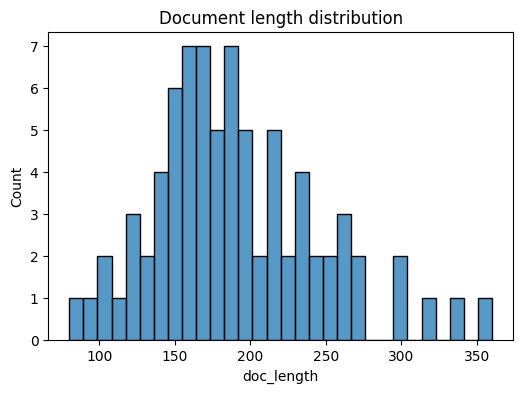

In [ ]:
df_raw["doc_length"] = df_raw["full_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df_raw["doc_length"], bins=30)
plt.title("Document length distribution")
plt.show()


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=20,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2
)
X = vectorizer.fit_transform(df_raw["full_text"])

pd.DataFrame({
    "term": vectorizer.get_feature_names_out(),
    "score": X.mean(axis=0).A1
}).sort_values("score", ascending=False)



,term,score
0,ad,0.451814
7,disease,0.217550
4,brain,0.160108
1,alzheimer,0.141547
9,drug,0.136638
18,therapeutic,0.136637
2,alzheimer disease,0.128920
16,targets,0.128073
19,treatment,0.120321
6,development,0.105711


In [ ]:
df_chunks_final = df_chunks.drop_duplicates(subset=["chunk_id"])
df_chunks_final.reset_index(drop=True, inplace=True)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df_raw.to_csv("/content/drive/MyDrive/data/pubmed_articles_full.csv", index=False)
df_chunks_final.to_csv("/content/drive/MyDrive/data/pubmed_chunks.csv", index=False)

